
# Information Conditions - Environmental State and Action Histories

> Plot learning trajectories under different information conditions of the Ecological Public Goods Game. a) Only environmental state history observable, b) only action history is observable, c) both environmental state and action histories are observable d) No information


In [2]:
import sys
sys.path.append('../pyCRLD')


In [3]:
#| export
import numpy as np
import matplotlib.pyplot as plt
import copy

from pyCRLD.Environments.SocialDilemma import SocialDilemma
from pyCRLD.Environments.EcologicalPublicGood import EcologicalPublicGood

from pyCRLD.Agents.StrategyActorCritic import stratAC
from pyCRLD.Agents.POStrategyActorCritic_eps import POstratAC_eps


from pyCRLD.Utils import FlowPlot as fp
from fastcore.utils import *
from jax import jit
import jax.numpy as jnp
from pyCRLD.Environments.HistoryEmbedding import HistoryEmbedded

from nbdev.showdoc import show_doc
from scipy.stats import kstest

from scipy.stats import qmc
import itertools as it
import pandas as pd

global_seed = 40
np.random.seed(global_seed)

In [4]:
#| export


ecopg = EcologicalPublicGood(N=2, f=1.2, c=5, m=-6, qc=0.02, qr= 0.0001, degraded_choice=True)
ecopg_with_history = HistoryEmbedded(ecopg, h = (1,1,1))

In [5]:
#| export

#average policy 

def average_policy_for_given_observation_set(X, O):
    """
    Takes in the strategy wrt to complete state set as input and returns the average strategy wrt to the given observation set. For example Strategty with respect to state set might
    have c, c, g = 0.2 and c, c, p = 0.8. But the observation set will be c, c, if only actions are observed. Then the average strategy for this observation set would be 0.5

    """
    A, S, F = X.shape        # Number of layers, states, and features
    _, _, num_obs = O.shape   # Number of observations

    # Initialize the output matrix with zeros
    output = np.zeros((A, num_obs, F))

    for i in range(A):
        for obs in range(num_obs):
            current_mask = O[i, :, obs]  # Shape: (S,)

            # Select rows from X where mask is 1
            selected_X = X[i][current_mask == 1]  # Shape: (num_selected_states, F)
            if selected_X.size > 0:
                mean_vector = selected_X.mean(axis=0)  # Shape: (F,)
            else:
                mean_vector = np.zeros(F)  # Default to zero vector
            output[i, obs, :] = mean_vector

    return output




In [6]:
show_doc(average_policy_for_given_observation_set)


---

### average_policy_for_given_observation_set

>      average_policy_for_given_observation_set (X, O)

*Takes in the strategy wrt to complete state set as input and returns the average strategy wrt to the given observation set. For example Strategty with respect to state set might
have c, c, g = 0.2 and c, c, p = 0.8. But the observation set will be c, c, if only actions are observed. Then the average strategy for this observation set would be 0.5*

In [6]:
#| export

#generate 
def generate_action_history_observation_set(stateset, number_of_agents):
    action_histories = [state[:3] for state in stateset]
    unique_action_histories = sorted(list(set(action_histories)))
    Oset = [unique_action_histories.copy() for _ in range(number_of_agents)]
    return Oset


def generate_state_observation_set(stateset, number_of_agents):
    state_histories = [state[4:] for state in stateset]
    unique_state_histories = sorted(list(set(state_histories)))
    Oset = [unique_state_histories.copy() for _ in range(number_of_agents)]
    return Oset



In [7]:
#| export

#information conditions class
class Information_Conditions(HistoryEmbedded):
    def __init__(self, ecopg , mode):


        super().__init__(ecopg, h=(1, 1, 1))

        self.mode = mode
        self.configure_information_condition()

    def configure_information_condition(self):
        """
        Set the observation mode and configure the observation tensor, Oset, and other properties.
        Modes: 'state', 'action', 'none', 'state+action'
        """
        if self.mode == "only_state_information":
            self._configure_state()
        elif self.mode == "only_action_history_information":
            self._configure_action()
        elif self.mode == "no_information":
            self._configure_none()
        elif self.mode == "both_state_and_action_information":
            self._configure_state_action()
        else:
            raise ValueError("Invalid mode..")
        # self._print_configuration()

        self.Q = self.O.shape[2]

    def _configure_state(self):
        def generate_state_tensor(state_set, observation_set):
            state_tensor = np.zeros((2, len(state_set), len(observation_set)), dtype=int)
            for i in range(2):
                for j, state in enumerate(state_set):
                    for k, observation in enumerate(observation_set):
                        if state.endswith(observation):
                            state_tensor[i, j, k] = 1
            return state_tensor
        
        
        self.Oset = generate_state_observation_set(self.Sset, 2)

        self.O = generate_state_tensor(
            self.Sset,  self.Oset[0])
        

    def _configure_action(self):
        def generate_action_tensor(state_set, action_set):
            action_tensor = np.zeros((2, len(state_set), len(action_set)), dtype=int)
            for i in range(2):  
                for j, state in enumerate(state_set):
                    for k, action in enumerate(action_set):
                        if action[:3] == state[:3]:
                            action_tensor[i, j, k] = 1
            return action_tensor

        self.Oset = generate_action_history_observation_set(self.Sset, self.N)
        self.O = generate_action_tensor(self.Sset, self.Oset[0])

    def _configure_none(self):
        def generate_none_tensor():
            return np.ones((2, 8, 1), dtype=int)

        self.O = generate_none_tensor()
        self.Oset = [['.'], ['.']]

    def _configure_state_action(self):
        # This assumes the default state+action information in `ecopg_with_history`
        pass
          # No modification needed; default setup already uses state+action information.


    def _print_configuration(self):
        print(f"Mode: {self.mode}")
        # print("Observation Tensor:\n", self.O)
        # print("Observation Set:", self.Oset)
        # print("O shape", self.O.shape)
        # print("Q shape", self.Q)

        print("------\n")


In [8]:
#| export

mae = POstratAC_eps(env= ecopg_with_history, learning_rates=0.1, discount_factors=0.9)
X_for_state_set = mae.random_softmax_strategy()    

#Just to initialise a random startegy for the state set. This will be used to get the average policy for the given observation set



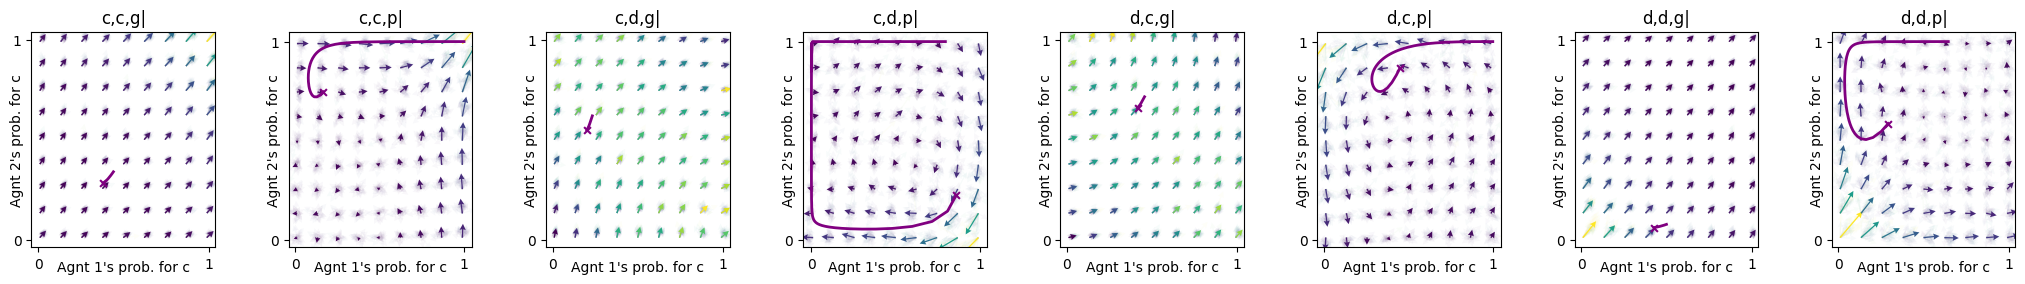

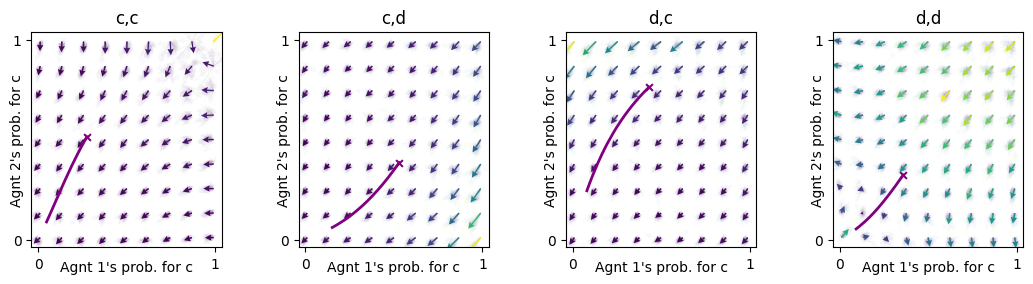

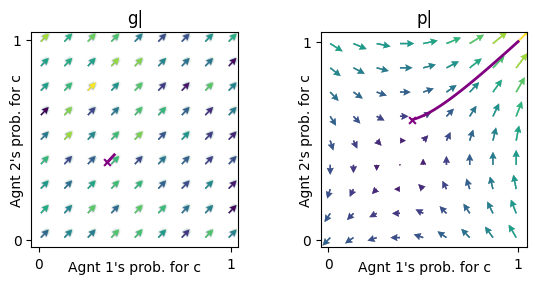

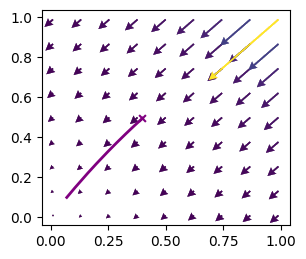

In [10]:
#| export

for mode in ['both_state_and_action_information','only_action_history_information', 'only_state_information','no_information', ]:
    #for each information condition get the average policy for the given observation set and plot the flow diagram

    
    information_condition_instance = Information_Conditions(ecopg, mode=mode)
    num_observed_states = len(information_condition_instance.Oset[0])
    x, y = ([0], list(range(num_observed_states)), [0]), ([1], list(range(num_observed_states)), [0])
    mae1 = POstratAC(env=information_condition_instance, learning_rates=0.1, discount_factors=0.98)

    ax = fp.plot_strategy_flow(
        mae1,
        x, y, flowarrow_points=np.linspace(0.01, 0.99, 9), NrRandom=32,
        conds=np.array(information_condition_instance.Oset)[0, :num_observed_states]  # Adjust conditions for the mode
    )

    X_for_observation_set = average_policy_for_given_observation_set(X_for_state_set, information_condition_instance.O)
    xtraj, fixedpointreached = mae1.trajectory(X_for_observation_set, Tmax=10000, tolerance=1e-5)

    fp.plot_trajectories([xtraj], x, y, cols=['purple'], axes = ax)

    # plt.figure()
    # plt.plot(xtraj[:, 0, 0, 0], label="Agent 0", c='red')
    # plt.plot(xtraj[:, 1, 0, 0], label="Agent 1", c='blue')
    # plt.xlabel('Time steps')
    # plt.ylabel('Cooperation probability')
    # plt.legend()
    # plt.title(mode + " trajectory")



### Experiments and Observations 

In [11]:
# np.set_printoptions(precision=4, suppress= True)


Complete state and action information - Monte Carlo analysis

In [9]:
def lhs_sampling(no_of_states, number_of_samples, agents):
    global global_seed
    sampler = qmc.LatinHypercube(d=no_of_states, seed = global_seed)

    # Sampling for each agent and stacking similar result lists
    lhs_random_samples_list = sampler.random(number_of_samples)
    result = [np.stack((random_samples, 1 - random_samples), axis=-1) for random_samples in lhs_random_samples_list]
    cross_product = [np.stack((x, y), axis=0) for x, y in it.combinations_with_replacement(result, agents)]

    return cross_product


In [10]:
def make_degraded_state_cooperation_probablity_zero(initial_condition, Oset):

    degraded_mask = jnp.array(['g' in label for label in Oset])
    initial_condition[:, degraded_mask, 0] = 0
    initial_condition[:, degraded_mask, 1] = 1

    return initial_condition



In [11]:
def exclude_degraded_states_from_obsdist_and_normalise(obsdist, Oset):
   
        # Exclude degraded states from the observation distribution

    degraded_mask = jnp.array(['g' in label for label in Oset])
    obsdist = jnp.where(degraded_mask, 0, obsdist)

    # Normalize rows to ensure sum of probabilities is 1
    row_sums = jnp.sum(obsdist, axis=1, keepdims=True)
    obsdist_excluding_degraded_states = jnp.where(row_sums > 0, obsdist / row_sums, obsdist)  # Avoid division by zero

    return obsdist_excluding_degraded_states

In [12]:
def get_average_cooperativeness(policy, obsdist, mode, Oset):

    if mode == 'only_state_information' or mode == 'both_state_and_action_information':
        obsdist = exclude_degraded_states_from_obsdist_and_normalise(obsdist, Oset)
    
    policy_cooperation_probabilities = policy[:,:, 0]
    agent_index, state_index = [0, 1]

    average_cooperation_for_each_agent = jnp.einsum(policy_cooperation_probabilities, [agent_index, state_index], obsdist, [agent_index, state_index], [agent_index])
    
    return average_cooperation_for_each_agent

In [16]:
#degraded choice is false

for mode in ['both_state_and_action_information', 'only_action_history_information', 'only_state_information', 'no_information']:
 
    # Initialize the information condition
    information_condition_instance = Information_Conditions(ecopg, mode=mode)
    mae = POstratAC_eps(env=information_condition_instance, learning_rates=0.1, discount_factors=0.9)

    # Data storage
    
    avg_coop_time_pairs = []
    num_samples = 8
    initial_conditions_list = lhs_sampling(mae.Q, num_samples, mae.N)

    print(f"\nMode: {mode}")

    # Monte Carlo Simulations
    for initial_condition in initial_conditions_list:

        initial_condition = make_degraded_state_cooperation_probablity_zero(initial_condition, information_condition_instance.Oset[0]) #to make sure all of them start at the same position in the degraded state (shouldn't it)
        xtraj, fixedpointreached = mae.trajectory(initial_condition, Tmax=10000, tolerance=1e-5)
        final_point = xtraj[-1]
        
        avg_coop_across_states = get_average_cooperativeness(policy=final_point, obsdist=mae.obsdist(final_point), mode = mode, Oset = mae.env.Oset[0])[0]
        time_to_reach = xtraj.shape[0]

        # Store cooperativeness and time as pairs (round cooperativeness to 2 decimals)
        avg_coop_time_pairs.append((round(avg_coop_across_states, 2), time_to_reach))

    # Create DataFrame for processing
    df = pd.DataFrame(avg_coop_time_pairs, columns=["AverageCooperation", "TimeToReach"])
    total_count = len(df)
    
    average_cooperation_across_initial_conditions = np.round(df['AverageCooperation'].agg('mean'), 3)
    print("Mean Final Cooperation Across Initial Conditions ", average_cooperation_across_initial_conditions)


    # Add a classification column
    def classify(avg_coop):
        if avg_coop < 0.1:
            return "Defection"
        elif avg_coop > 0.9:
            return "Cooperation"
        else:
            return "Mixed"


    df['Classification'] = df['AverageCooperation'].apply(classify)
    average_cooperation_across_initial_conditions = df['AverageCooperation'].agg('mean')
    # Reporting unique entries

    # Overall Summary
    summary = df.groupby('Classification')['TimeToReach'].agg(
        MedianTimetoReach='median',
        Percentage= lambda x: round((len(x) / total_count) * 100,1)
    ).reset_index()
    
    print(summary)



Mode: both_state_and_action_information
Mean Final Cooperation Across Initial Conditions  0.0
  Classification  MedianTimetoReach  Percentage
0      Defection               87.0       100.0

Mode: only_action_history_information
Mean Final Cooperation Across Initial Conditions  0.18
  Classification  MedianTimetoReach  Percentage
0      Defection            10000.0        41.7
1          Mixed            10000.0        58.3

Mode: only_state_information
Mean Final Cooperation Across Initial Conditions  0.0
  Classification  MedianTimetoReach  Percentage
0      Defection               74.0       100.0

Mode: no_information
Mean Final Cooperation Across Initial Conditions  0.074
  Classification  MedianTimetoReach  Percentage
0      Defection            10000.0        75.0
1          Mixed            10000.0        25.0


Extracting Final Strategies

In [13]:

def get_unique_arrays(list_of_arrays):
    """

    Args:
        arrays (list of np.ndarray): List of NumPy arrays to check for uniqueness.

    Returns:
        list of np.ndarray: A list of unique arrays restored to their original shapes.
    """
    list_of_unique_arrays = [list_of_arrays[0]]  #the first element of array is always uniqyue
    for array in list_of_arrays:
        is_unqiue = True
        for unique_array in list_of_unique_arrays:
            if  np.allclose(array, unique_array, rtol = 0.01) or  np.allclose(array, np.flip(unique_array, axis = 0), rtol = 0.01):
                is_unqiue = False
                break
        if is_unqiue:            
            list_of_unique_arrays.append(array)
    return list_of_unique_arrays




In [18]:

# Assuming required classes and functions are defined or imported
# Initialize the ecological public goods game

# List of modes to iterate through
modes = ['only_action_history_information', 'no_information', 'only_state_information', 'both_state_and_action_information']

# Data storage for results
results_unique = {}
results_all = {}
obdsist_all = {}
# Iterate through each mode

for mode in modes:
    # Initialize the information condition
    information_condition_instance = Information_Conditions(ecopg, mode=mode)
    mae = POstratAC_eps(env=information_condition_instance, learning_rates=0.1, discount_factors=0.9)

    # Generate initial conditions using Latin hypercube sampling
    num_samples = 8
    initial_conditions_list = lhs_sampling(mae.Q, num_samples, mae.N)
    # Print the mode
    print(f"\nMode: {mode}")

    # Store unique points for this mode
    final_point_list = []
    obsdist_list = []

    # Monte Carlo Simulations
    for initial_condition in initial_conditions_list:
        
        initial_condition = make_degraded_state_cooperation_probablity_zero(initial_condition, information_condition_instance.Oset[0])

        xtraj, fixedpointreached = mae.trajectory(initial_condition, Tmax=10000, tolerance=1e-5)
        final_point = xtraj[-1]

        # Round off to 4 decimal places
        rounded_point = np.round(final_point, 1)
        
        #obsdist points 
        obsdist = mae.obsdist(final_point)
        obsdist_list.append(obsdist)

        # Get unique points
        final_point_list.append(rounded_point)

    # Save results for the current mode
    results_unique[mode] = get_unique_arrays(final_point_list)
    results_all[mode] = final_point_list
    obdsist_all[mode] = obsdist_list

# The `results` dictionary contains the processed unique points for each mode

print(results_unique['only_action_history_information'])



Mode: only_action_history_information

Mode: no_information

Mode: only_state_information

Mode: both_state_and_action_information
[array([[[0.2, 0.8],
        [0.5, 0.5],
        [0.2, 0.8],
        [0.1, 0.9]],

       [[0.1, 0.9],
        [0.3, 0.7],
        [0.1, 0.9],
        [0. , 1. ]]]), array([[[0.1, 0.9],
        [0.3, 0.7],
        [0.1, 0.9],
        [0. , 1. ]],

       [[0. , 1. ],
        [0.1, 0.9],
        [0. , 1. ],
        [0.2, 0.8]]]), array([[[0. , 1. ],
        [0. , 1. ],
        [0. , 1. ],
        [0. , 1. ]],

       [[0. , 1. ],
        [0. , 1. ],
        [0.5, 0.5],
        [0.1, 0.9]]]), array([[[0.1, 0.9],
        [0.2, 0.8],
        [0.1, 0.9],
        [0. , 1. ]],

       [[0.3, 0.7],
        [0.1, 0.9],
        [0.1, 0.9],
        [0.2, 0.8]]]), array([[[0. , 1. ],
        [0. , 1. ],
        [0. , 1. ],
        [0. , 1. ]],

       [[0. , 1. ],
        [0. , 1. ],
        [0.2, 0.8],
        [0.7, 0.3]]]), array([[[0.5, 0.5],
        [0.4, 0.6],
  

Question: Why is this happening?

1. Why are there some random mid-values in case of only action information. Check if this happens in case of memory1pd
2. 

'''here I attempt to compare the two trajectoris as a whole, which is stratAC and POstratAC.
 I will compare the two trajectories for the same initial conditions and see if they converge to the same point.'''

The flowplots appear similar based on visual inspection. Let me compare the trajectories for the same initial conditions.

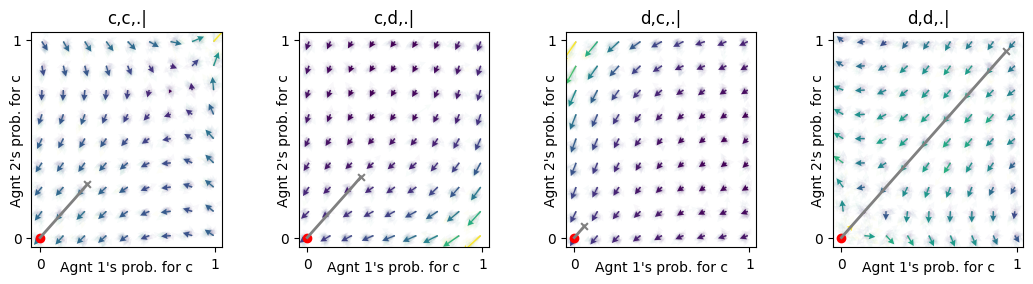

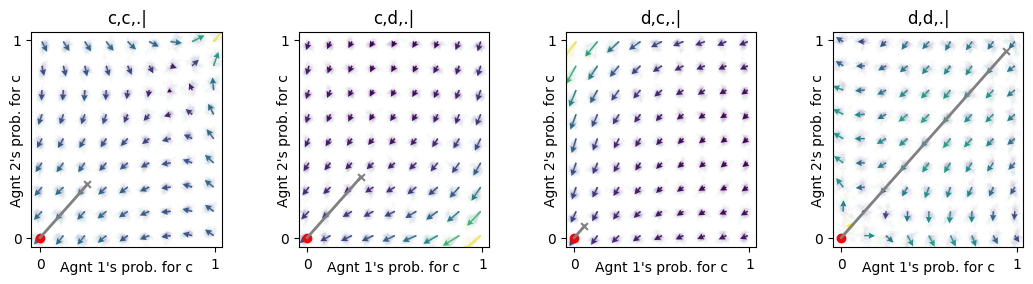

In [19]:

socdi = SocialDilemma(R=1.0, T=1.2, S=-0.5, P=0.0)

memo1pd = HistoryEmbedded(socdi, h = (1, 1, 1))


# Initialize the information condition
mae_strat = stratAC(env=memo1pd, learning_rates=0.1, discount_factors=0.9)
mae_postrat = POstratAC(env=memo1pd, learning_rates=0.1, discount_factors=0.9)

# Generate initial conditions using Latin hypercube sampling
num_samples = 1

initial_conditions_list = lhs_sampling(mae_strat.Q, num_samples, mae_strat.N)  #same initial condition for both

x = ([0], [0,1,2,3], [0])
y = ([1], [0,1,2,3], [0])

ax_stratAC = fp.plot_strategy_flow(mae_strat, x, y, flowarrow_points=np.linspace(0.01 ,0.99, 9), NrRandom=32, conds = mae_strat.env.Oset[0])

ax_POstratAC = fp.plot_strategy_flow(mae_postrat, x, y, flowarrow_points=np.linspace(0.01 ,0.99, 9), NrRandom=32, conds = mae_postrat.env.Oset[0])

# Store unique points for this mode

xtraj_stratAC_list = []
xtraj_postratAC_list = []

final_point_list_stratAC = []
final_point_list_postratAC = []

# Monte Carlo Simulations
for initial_condition in initial_conditions_list:


    '''stratAC'''
    xtraj_stratAC, fixedpointreached_stratAC = mae_strat.trajectory(initial_condition, Tmax=10000, tolerance=1e-5)
    final_point_stratAC = xtraj_stratAC[-1]

    xtraj_stratAC_list.append(xtraj_stratAC)

    # print(mae.obsdist(final_point))

    fp.plot_trajectories([xtraj_stratAC], x, y, cols=['grey'], lss = "--", axes = ax_stratAC)
    # Round off to 4 decimal places
    rounded_point_stratAC = np.round(final_point_stratAC, 1)

    # print(rounded_point)
    # Get unique points
    final_point_list_stratAC.append(rounded_point_stratAC)
    
    for plot_index, (x_indices,y_indicies) in enumerate(zip(it.product(*x), it.product(*y))):
        ax_stratAC[plot_index].scatter(final_point_stratAC[x_indices],final_point_stratAC[y_indicies], color = 'red')
    

    '''POstratAC'''


    xtraj_postratAC, fixedpointreached_postratAC = mae_postrat.trajectory(initial_condition, Tmax=10000, tolerance=1e-5)
    final_point_postratAC = xtraj_postratAC[-1]

    xtraj_postratAC_list.append(xtraj_postratAC)

    # print(mae.obsdist(final_point))

    fp.plot_trajectories([xtraj_postratAC], x, y, cols=['grey'], lss = "--", axes = ax_POstratAC)
    # Round off to 4 decimal places
    rounded_point_postratAC = np.round(final_point_postratAC, 1)

    # print(rounded_point)
    # Get unique points
    final_point_list_postratAC.append(rounded_point_postratAC)


    
    for plot_index, (x_indices,y_indicies) in enumerate(zip(it.product(*x), it.product(*y))):
        ax_POstratAC[plot_index].scatter(final_point_postratAC[x_indices],final_point_postratAC[y_indicies], color = 'red')






# print(ax)

# print(final_point_list)



#     # results_memo1pd = get_unique_arrays(final_point_list)




In [20]:


traj_differs_at = None

for i in range(xtraj_postratAC.shape[0]):
    if not np.array_equal(xtraj_postratAC[i, :, :, :], xtraj_stratAC[i, :, :, :]):
        print('stratAC and POstratAc traj differs at ', i)
        traj_differs_at = i
        break   

# for i in range(xtraj_postratAC.shape[0]):
#     if not np.array_equal(mae_postrat.obsdist(xtraj_postratAC[i, :, :, :])[0], mae_strat.Ps(xtraj_stratAC[i, :, :, :])):
#         print(i)
#         break   


# print(xtraj_postratAC.shape[0], "length of the trajectory POstratAC")
# print(xtraj_stratAC.shape[0], "length of the trajectory stratAC")



for i in range(xtraj_postratAC.shape[0]):
    if not np.array_equal(mae_postrat.obsdist(xtraj_postratAC[i, :, :, :])[0], mae_postrat.Ps(xtraj_stratAC[i, :, :, :])):
        print('the obsdist and stat dist differs from',i)
        break   




np.set_printoptions(precision = 9, suppress= True)




# print("the X value at ", traj_differs_at,  " for postratAC is ", xtraj_postratAC[172, :, :, :])
print("the  StateDist of stratac just before deviation point", mae_strat.Ps(xtraj_stratAC[ traj_differs_at -1 , :, :, :]))
print("the  StateDist of postratac just before deviation point", mae_strat.Ps(xtraj_postratAC[ traj_differs_at -1 , :, :, :]))
print("the  Obdsist of postratac just before deviation point", mae_postrat.obsdist(xtraj_postratAC[traj_differs_at -1, :, :, :])[0])

print(mae_strat.Ps(xtraj_stratAC[ traj_differs_at -1 , :, :, :]) - mae_postrat.obsdist(xtraj_postratAC[traj_differs_at -1, :, :, :])[0])



stratAC and POstratAc traj differs at  223
the obsdist and stat dist differs from 222
the  StateDist of stratac just before deviation point [0.          0.000920703 0.000923093 0.9981562  ]
the  StateDist of postratac just before deviation point [0.          0.000920703 0.000923093 0.9981562  ]
the  Obdsist of postratac just before deviation point [0.          0.000920701 0.000923095 0.9981562  ]
[ 0.           0.000000002 -0.000000002  0.         ]
